# Modelo AR(p) Disney
Katlyn Goeujon-Mackness <br>
29/04/2025

## Introducción
### Objetivo
Breve descripción del objetivo del análisis.

### Modelos AR(p)
**El modelo AR(1), o modelo autoregresivo de orden 1**, se utiliza en series de tiempo para predecir el valor actual de una variable basándose en su valor inmediatamente anterior. Es el modelo autoregresivo más básico y se utiliza como base para modelos más complejos, como AR(p) de órdenes superiores.

#### Componentes
* media constante mu (𝜇)
* coeficiente phi (𝜙)
* término de error de ruido blanco

El modelo es especialmente útil para series temporales estacionarias donde 𝜙 está entre -1 y 1, con dos casos importantes:
1. 𝜙 positivo: Con "Momentum", genera una correlación positiva y un crecimiento que decae con el tiempo.
2. 𝜙 negativo: Con inversión de media, produce alternancias entre subidas y bajadas en las observaciones.

### Contexto del Conjunto de Datos
Consideraremos la información histórica diaria de precios para la empresa Walt Disney Company (cuya sigla bursátil es “DIS”) contenida en el sitio de Yahoo Finance para el periodo que va del 1 de Enero del 2023 al 31 de Marzo del 2023 usando los modelos auto-regresivos AR(p).

## Implementación
Utilizaremos librerías estadísticas para implementar modelos AR(1) en el análisis de precios de acciones. Veremos cómo ajustar modelos a datos de entrenamiento y realizar predicciones precisas.

In [24]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_squared_error

In [25]:
# Solucionar un problema de yfinance
from curl_cffi import requests
session = requests.Session(impersonate="chrome")
ticker = yf.Ticker("DIS", session=session)

In [26]:
# Cargar los datos históricos desde Yahoo Finance
disney = yf.download(tickers="DIS", start='2023-01-01', end='2023-03-31', rounding=True)
disney

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS
Date,,,,,
2023-01-03,87.88,88.87,86.76,87.89,14997100
2023-01-04,90.86,91.62,88.27,88.90,14957200
2023-01-05,90.80,91.35,89.41,90.54,11622600
2023-01-06,92.77,93.53,90.21,91.53,9828100
2023-01-09,93.61,94.53,92.31,93.28,11675800
...,...,...,...,...,...
2023-03-24,92.93,93.84,91.88,93.65,9534600
2023-03-27,94.45,94.85,93.23,93.62,7487900


In [27]:
# Save the Disney data to a CSV file
disney.to_csv('disney_data.csv', index=True)

In [28]:
disney = disney['Close']
disney

Ticker,DIS
Date,
2023-01-03,87.88
2023-01-04,90.86
2023-01-05,90.80
2023-01-06,92.77
2023-01-09,93.61
...,...
2023-03-24,92.93
2023-03-27,94.45
2023-03-28,93.66


## Exploración de Datos

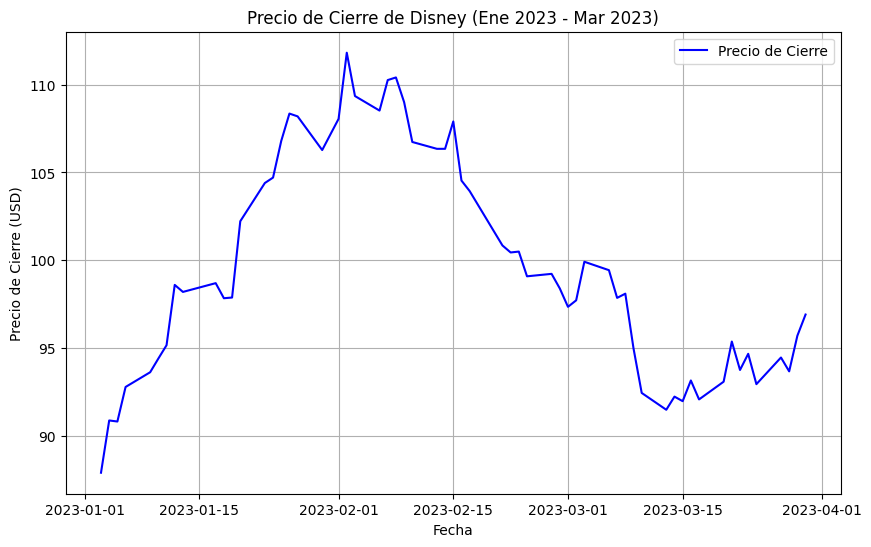

In [29]:
# Graficar los datos de cierre de Disney
plt.figure(figsize=(10, 6))
plt.plot(disney, label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre de Disney (Ene 2023 - Mar 2023)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid()
plt.show()

  ### Selección del Modelo AR(p)

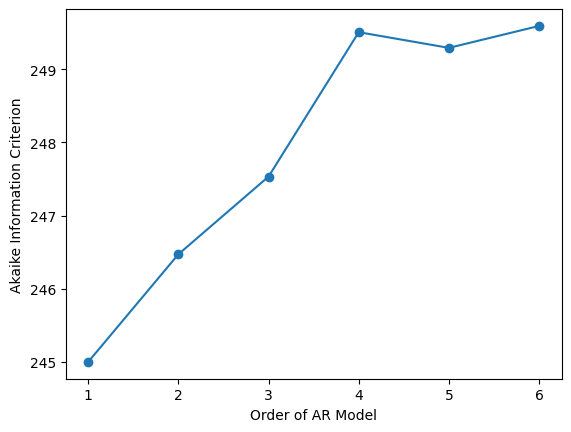

In [30]:
# Determinación del valor adadecuado de p para AR(p) apartir
#  del criterio de información Akaike

AIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(disney, order=(p,0,0))
    res = mod.fit()
    AIC[p] = res.aic

# Plot the BIC as a function of p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()

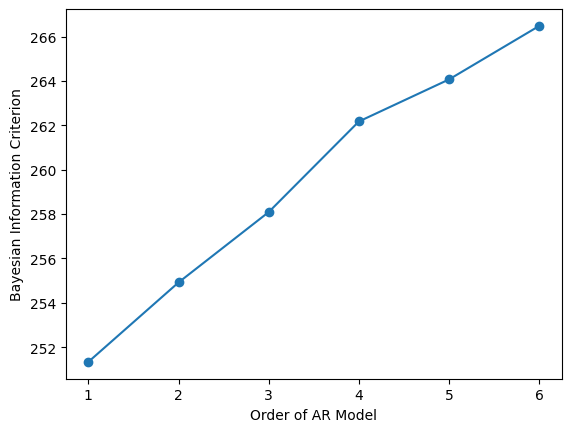

In [31]:
# Determinación del valor adadecuado de p para AR(p) apartir
#  del criterio de información Bayesiano

BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(disney, order=(p,0,0))
    res = mod.fit()
    BIC[p] = res.bic

# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

Conclusión: Según los criterios de información Akaike y Bayesiano, el valor p óptimo es **1**.

## Modelación

### División de Datos

In [32]:
# Dividir los datos en conjuntos de entrenamiento (70%) y prueba (30%).
disney.index = pd.to_datetime(disney.index)
len_train = int(len(disney)*0.8)
len_train
# Ajustar el índice para usar fechas.

48

In [33]:
len_test = int(len(disney)*0.2)
len_test

12

In [34]:
# Definición de grupos de prueba y entrenamiento
train = disney[0:len_train]

test = disney[len_train:]

[ 1.          0.88409269  0.78141411  0.68480282  0.61334895  0.52990295
  0.4452171   0.35834498  0.2820985   0.18754477  0.07604041 -0.03183198
 -0.14796236 -0.23437843 -0.31015931 -0.39229674 -0.43506145]


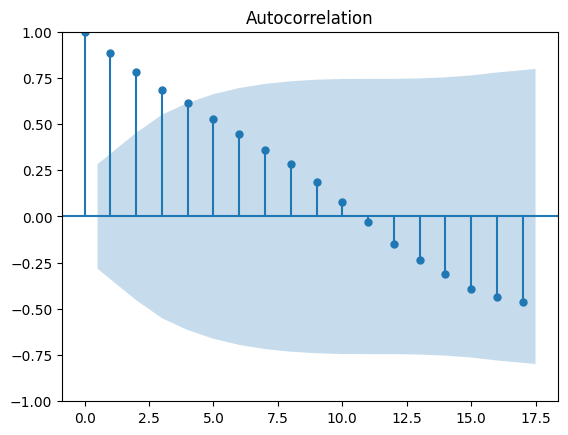

In [35]:
# Generar gráficos de autocorrelación (ACF) y autocorrelación parcial (PACF).
acf_array = acf(train)
print(acf_array)

# Gráfico con un nivel de confianza del 95%
plot_acf(train, alpha=0.05)
plt.show()


Conclusión: La disminución gradual de los puntos sugiere la presencia de una tendencia en los datos. Además, al observar que los valores cruzan la línea de cero, se puede inferir un comportamiento estacional en la serie temporal.

### Ajuste del Modelo

In [36]:
# Entrenar el modelo AR(p) seleccionado en el conjunto de entrenamiento.

# Ajusta un modelo AR(1) con herramientas de Python, prediciendo los valores futuros
mod = ARIMA(train, order=(1,0,0))
res = mod.fit()

# Evaluar el ajuste del modelo.
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    DIS   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -96.554
Date:                Fri, 02 May 2025   AIC                            199.107
Time:                        23:11:15   BIC                            204.721
Sample:                             0   HQIC                           201.229
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.1984      8.815     10.686      0.000      76.921     111.476
ar.L1          0.9736      0.034     28.682      0.000       0.907       1.040
sigma2         3.0760      0.655      4.697      0.0

Conclusión: Este modelo captura una relación autorregresiva, que indica que los valores pasados influyen mucho los del futuro.

### Pronóstico

In [37]:
# Generar predicciones puntuales 
predicciones = res.forecast(len(test))
predicciones

48    91.541969
49    91.612039
50    91.680261
51    91.746684
52    91.811355
53    91.874320
54    91.935623
55    91.995310
56    92.053423
57    92.110003
58    92.165090
59    92.218724
60    92.270943
Name: predicted_mean, dtype: float64

In [38]:
# Calcular intervalos de confianza del 90% para las predicciones.
# Calcula los intervales de confianza
conf = res.get_forecast(len(test)).conf_int(alpha=0.05)
conf

,lower DIS,upper DIS
48,88.104495,94.979442
49,86.814404,96.409675
50,85.880669,97.479854
51,85.136050,98.357318
52,84.514663,99.108046
53,83.982157,99.766482
54,83.517792,100.353455
55,83.107835,100.882786
56,82.742598,101.364248
57,82.414920,101.805085


In [39]:
# Pronóstico de los siguientes 5 períodos posteriores al último dato histórico
predicciones = res.forecast(len(test) + 30)
predicciones


48    91.541969
49    91.612039
50    91.680261
51    91.746684
52    91.811355
53    91.874320
54    91.935623
55    91.995310
56    92.053423
57    92.110003
58    92.165090
59    92.218724
60    92.270943
61    92.321785
62    92.371286
63    92.419482
64    92.466406
65    92.512092
66    92.556573
67    92.599881
68    92.642047
69    92.683100
70    92.723070
71    92.761986
72    92.799876
73    92.836766
74    92.872683
75    92.907653
76    92.941701
77    92.974850
78    93.007125
79    93.038548
80    93.069143
81    93.098931
82    93.127932
83    93.156169
84    93.183662
85    93.210429
86    93.236489
87    93.261863
88    93.286567
89    93.310620
90    93.334038
Name: predicted_mean, dtype: float64

In [40]:
conf = res.get_forecast(len(test) + 30).conf_int(alpha=0.05)
conf

,lower DIS,upper DIS
48,88.104495,94.979442
49,86.814404,96.409675
50,85.880669,97.479854
51,85.136050,98.357318
52,84.514663,99.108046
53,83.982157,99.766482
54,83.517792,100.353455
55,83.107835,100.882786
56,82.742598,101.364248
57,82.414920,101.805085


In [41]:
test = pd.DataFrame(test)
test = test.reset_index()

predicciones = pd.DataFrame(predicciones)
predicciones = predicciones.reset_index()

In [42]:
test

Ticker,Date,DIS
0,2023-03-14,92.22
1,2023-03-15,91.96
2,2023-03-16,93.14
3,2023-03-17,92.06
4,2023-03-20,93.07
5,2023-03-21,95.36
6,2023-03-22,93.74
7,2023-03-23,94.66
8,2023-03-24,92.93
9,2023-03-27,94.45


In [43]:
predicciones

,index,predicted_mean
0,48,91.541969
1,49,91.612039
2,50,91.680261
3,51,91.746684
4,52,91.811355
5,53,91.874320
6,54,91.935623
7,55,91.995310
8,56,92.053423
9,57,92.110003


In [44]:
# Preparar datos para pronosticar
train = pd.DataFrame(train)
lista = test['Date']
lista = pd.DataFrame(lista)

test.index = test['Date']
test.drop(columns=['Date'], inplace=True)
test

Ticker,DIS
Date,
2023-03-14,92.22
2023-03-15,91.96
2023-03-16,93.14
2023-03-17,92.06
2023-03-20,93.07
2023-03-21,95.36
2023-03-22,93.74
2023-03-23,94.66
2023-03-24,92.93


### Evaluación del Modelo

In [45]:
# Calcular métricas de error como RMSE y MAPE.
acumulador1  = 0
acumulador2  = 0

for contador in range(0,12):
    acumulador1 = acumulador1 + (test.iloc[contador][1] - predicciones.iloc[contador][1]) ** 2
    acumulador2 = acumulador2 + np.abs((test.iloc[contador][1] - predicciones.iloc[contador][1]) / 
                                       test.iloc[contador][1])
    
mse = acumulador1 / 12
rmse = np.round(np.sqrt(mse),2)
mape = np.round((acumulador2 / 12) * 100,2)

print("RMSE:", rmse, "\nMAPE:", mape, "%")


IndexError: index 1 is out of bounds for axis 0 with size 1

Conclusión: En promedio, el modelo tiene un error de aproximadamente $1.99. Este valor bajo sugiere más precisión. Además, el MAPE bajo de 5% sugiere un modelo muy preciso. Esto indica que el model está capturando bein los patrones de la serie temporal analizada.

## Visualización de Resultados

In [ ]:
# Graficar los datos históricos, predicciones y sus intervalos de confianza.

# Usar colores para distinguir los diferentes conjuntos de datos.

## Conclusiones

In [ ]:
# Resumir los hallazgos del análisis.

# Reflexionar sobre la precisión del modelo y posibles mejoras.